In [ ]:
##Install relevant packages required
# pip install matplotlib
# pip install opencv-python
# pip install tensorflow_hub
# pip install pandas
# pip install sklearn
# pip install tqdm
# pip install ipywidgets --user

### I will be using transfer learning and take pre-trained model from google's Tensorflow Hub and re-train the last layer on our training dataset because using pre-trained model saves lot of time and computational budget for new classification problem at hand

Import relevant packages

In [15]:
import numpy as np
import cv2
import matplotlib.pylab as plt
import PIL.Image as Image
import os
import pandas as pd
import glob
import csv
import tensorflow as tf
import tensorflow_hub as hub

In [2]:
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential 

### Setting the path to load training dataset and label

In [20]:
train_img_path = r'C:\Users\User\OneDrive\Desktop\video_dsta\ml-dev\training_data\\'
train_label = r'C:\Users\User\OneDrive\Desktop\video_dsta\ml-dev\labels.csv'

In [21]:
image_list = glob.glob(os.path.join(train_img_path, "*"))
len(image_list)

900

In [58]:
x_train = []
y_train = []

Read images from disk into numpy array 

In [59]:
with open(train_label, "rt") as dataset:
    reader = csv.reader(dataset)
    next(reader, None)

    for line in tqdm(reader, total=900):
        x_train.append(
                np.asarray(
                    # Load image Without Grayscale Flag and change image to our target size of 224 by 224
                    load_img(
                        train_img_path + line[0] , target_size=(224,224,3), color_mode="rgb"
                    )
                )
            #)
        )
        y_train.append(int(line[1]))

  0%|          | 0/900 [00:00<?, ?it/s]

In [60]:
X = x_train
y = y_train

Performing train test split

In [84]:
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size= 0.7, random_state=1337)

Preprocessing of images by performing Data Scaling to Improve Deep Learning Model Stability and Performance

In [85]:
x_train_scaled = [x / 255 for x in x_train] 
x_val_scaled = [x / 255 for x in x_val] 

In [86]:
x_train_scaled = np.array(x_train_scaled)
x_val_scaled = np.array(x_val_scaled)
y_train = np.array(y_train)
y_val = np.array(y_val)

#### I will be using pre-trained model(mobilenet_v2) imported from tensorflow hub. I will freeze and use the trained weights of the mobilenet_v2 model and only retrain the last layer using our own training images.

In [30]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
pretrained_model_without_top_layer = hub.KerasLayer(
feature_extractor_model, input_shape= (224,224,3), trainable = False)   #trainable = false

In [104]:
#model will do prediction for 5 classes
num_of_ship_class = 5
model = tf.keras.Sequential([pretrained_model_without_top_layer,
                            tf.keras.layers.Dense(num_of_ship_class)])
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense_9 (Dense)              (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [71]:
#Sparse Categorical Crossentropy
#If you have two or more classes and  the labels are integers, the SparseCategoricalCrossentropy should be used.

In [105]:
model.compile(
    optimizer = "adam",
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["acc"])

history = model.fit(x_train_scaled, y_train, epochs=12 ,validation_data = (x_val_scaled, y_val))

Epoch 1/12
9/9 [==============================] - 9s 1s/step - loss: 1.3671 - acc: 0.4593 - val_loss: 1.1563 - val_acc: 0.6238
Epoch 2/12
9/9 [==============================] - 8s 970ms/step - loss: 0.9074 - acc: 0.7259 - val_loss: 0.8825 - val_acc: 0.7270
Epoch 3/12
9/9 [==============================] - 8s 978ms/step - loss: 0.6662 - acc: 0.8259 - val_loss: 0.7441 - val_acc: 0.7746
Epoch 4/12
9/9 [==============================] - 8s 1s/step - loss: 0.5231 - acc: 0.8630 - val_loss: 0.6479 - val_acc: 0.7984
Epoch 5/12
9/9 [==============================] - 8s 974ms/step - loss: 0.4331 - acc: 0.8852 - val_loss: 0.5921 - val_acc: 0.8222
Epoch 6/12
9/9 [==============================] - 8s 1s/step - loss: 0.3706 - acc: 0.9185 - val_loss: 0.5576 - val_acc: 0.8270
Epoch 7/12
9/9 [==============================] - 9s 1s/step - loss: 0.3277 - acc: 0.9370 - val_loss: 0.5291 - val_acc: 0.8286
Epoch 8/12
9/9 [==============================] - 9s 1s/step - loss: 0.2970 - acc: 0.9444 - val_loss: 

In [99]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


Train Learning Curve: Learning curve calculated from the training dataset that gives an idea of how well the model is learning.

Validation Learning Curve: Learning curve calculated from a hold-out validation dataset that gives an idea of how well the model is generalizing.

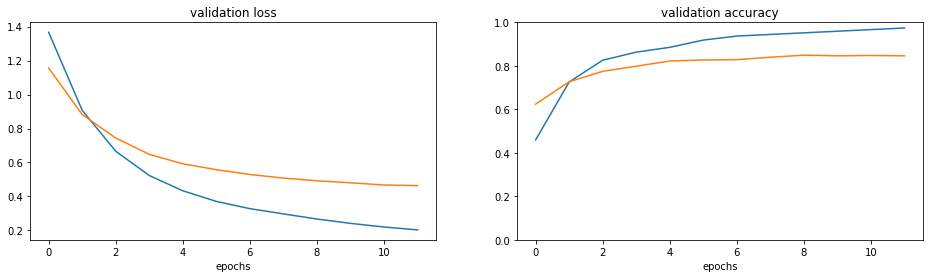

In [106]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["loss"])
ax.plot(history.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["acc"])
ax2.plot(history.history["val_acc"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

The learning curve charts show a good fit because the training loss decreases to a point of stability and the validation loss decreases to a point of stability and has a small gap with the training loss. We can further improve our model with more datasets and fine tuning.

After 12 epoch, the model managed to achieve training and validation loss that decreases to a point of stability with a minimal gap between the two final loss values. The loss of model on the training dataset is lower than the validation dataset (generalization gap). 

In [107]:
model.evaluate(x_val_scaled,y_val)

20/20 [==============================] - 6s 278ms/step - loss: 0.4634 - acc: 0.8460


[0.46337440609931946, 0.8460317254066467]

### Making a prediction 

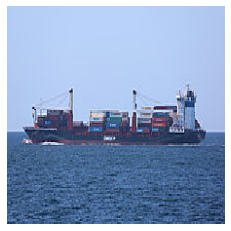

True label: 0
Predicted label: 0


In [96]:
x, y = x_val_scaled,y_val
image = x[0, :, :, :]
true_index = np.argmax(y[0])
plt.imshow(image)
plt.axis('off')
plt.show()

# Expand the validation image to (1, 224, 224, 3) before predicting the label
prediction_scores = model.predict(np.expand_dims(image, axis=0))
predicted_index = np.argmax(prediction_scores)
print("True label: " + str(true_index))
print("Predicted label: " + str(predicted_index))

### Creating model path and saving model 

In [98]:
saved_model_path = r'C:\Users\User\OneDrive\Desktop\video_dsta\ml-dev\trained_model'
tf.saved_model.save(model, saved_model_path)

INFO:tensorflow:Assets written to: C:\Users\User\OneDrive\Desktop\video_dsta\trained_model\assets


INFO:tensorflow:Assets written to: C:\Users\User\OneDrive\Desktop\video_dsta\trained_model\assets
